# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: Denoising MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [93]:
# import libraries
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_20196\3064566235.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [94]:
# import dataset (comes with colab!)
data = np.loadtxt(open('FFN/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [95]:
# create a class for the model
def createTheMNISTAE(n_encode: int, n_bottleneck: int):

  class aenet(nn.Module):
    def __init__(self, n_encode: int, n_bottleneck: int):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,n_encode)
      
      ### encoder layer
      self.enc = nn.Linear(n_encode,n_bottleneck)

      ### latent layer
      self.lat = nn.Linear(n_bottleneck,n_encode)

      ### decoder layer
      self.dec = nn.Linear(n_encode,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet(n_encode, n_bottleneck)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [96]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE(500, 10)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


# Create a function that trains the model

In [97]:
def create_dataloader(dataT: torch.tensor, batch_size: int):
  number_of_batches = dataT.shape[0] // batch_size
  samples_to_discard = dataT.shape[0] % batch_size
  indices_to_remove = np.arange(dataT.shape[0] - samples_to_discard, data.shape[0])
  dataAdj = np.delete(dataT, indices_to_remove, axis=0)
  reshaped_data = dataAdj.reshape((number_of_batches, batch_size, dataT.shape[-1]))
  return reshaped_data

reshaped_data = create_dataloader(dataT, 32)
print(dataT.shape)
print(reshaped_data.shape)
print(dataT.flatten().size())
print(reshaped_data.flatten().size())

torch.Size([20000, 784])
torch.Size([625, 32, 784])
torch.Size([15680000])
torch.Size([15680000])


In [98]:
def function2trainTheModel(n_encode: int, n_bottleneck: int):

  # number of epochs
  numepochs = 15
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(n_encode, n_bottleneck)

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    sys.stdout.write(f"\rRunning... [{epochi}/{numepochs}].")
    sys.stdout.flush()

    data_loader = create_dataloader(dataT, batch_size=128)
    number_of_batches = data_loader.shape[0]
    for X in data_loader:
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # losses in this epoch
      losses[epochi] += loss.item() / number_of_batches
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [100]:
encoding_sizes = np.linspace(10, 500, 12).astype(int)
bottleneck_sizes = np.linspace(5, 100, 8).astype(int)

losses = np.zeros((len(encoding_sizes), len(bottleneck_sizes)))

for es_idx, es in enumerate(encoding_sizes):
  for bs_idx, bs in enumerate(bottleneck_sizes):
    losses[es_idx, bs_idx] = torch.mean(function2trainTheModel(encoding_sizes, bottleneck_sizes)[0][-3:]).item()

print("Done!")

Running... [9/10].

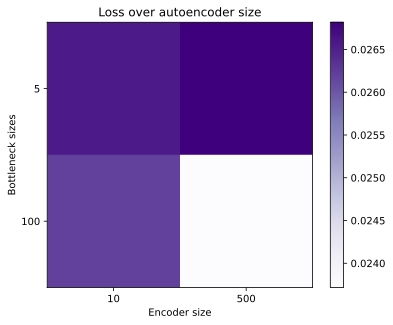

In [108]:

plt.figure()

plt.imshow(losses, cmap="Purples")
plt.colorbar()
plt.xticks(range(len(encoding_sizes)), encoding_sizes)
plt.yticks(range(len(bottleneck_sizes)), bottleneck_sizes)

plt.xlabel("Encoder size")
plt.ylabel("Bottleneck sizes")
plt.title("Loss over autoencoder size")

plt.show()
